# **SOCIAL NETWORK ANALYSIS INITIALIZATION**

This project implements advanced graph algorithms for social network analysis:
- Community detection (Girvan-Newman, Louvain)
- Centrality metrics (degree, betweenness, PageRank)
- Network visualization and clustering

Dataset: Facebook Social Network (Kaggle)

In [ ]:
!pip install networkx matplotlib seaborn pandas numpy scipy python-louvain

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import community as community_louvain
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# **SECTION 1: DATA LOADING & NETWORK GENERATION**


This section loads or generates a social network graph for analysis.

**What it does:**
- Defines a flexible function that can load real Facebook network data from CSV files OR generate synthetic networks
- If you have real data (e.g., from Kaggle), it reads edge lists in "source,target" format
- If no data is provided, it creates a realistic synthetic social network using the Barabási-Albert model
- Returns a NetworkX graph object ready for analysis

**Why Barabási-Albert model?**
The BA model generates scale-free networks with power-law degree distributions—a characteristic of real social networks where:
- Few "influencers" have many connections (hubs)
- Most users have few connections
- Network exhibits "preferential attachment": popular nodes attract more connections

**Model parameters:**
- n=500: Creates 500 nodes (users)
- m=3: Each new node connects to 3 existing nodes
- seed=42: Ensures reproducible results

**Output:** A graph G with 500 nodes and ~1,491 edges (3*500 - initial clique edges)



In [ ]:
def load_facebook_network(file_path=None):
    if file_path:
        # Load from file
        edges_df = pd.read_csv(file_path, header=None, names=['source', 'target'])
        G = nx.from_pandas_edgelist(edges_df, 'source', 'target')
    else:
        # Generate synthetic social network (scale-free graph)
        print("Generating synthetic social network (Barabási-Albert model)...")
        G = nx.barabasi_albert_graph(n=500, m=3, seed=42)

    print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Generate or load network
G = load_facebook_network()  # Use file_path='facebook_edges.csv' if you have data

Generating synthetic social network (Barabási-Albert model)...
Network loaded: 500 nodes, 1491 edges


# **SECTION 2: NETWORK STATISTICS**


This section computes fundamental graph metrics that characterize the network's structure and connectivity.

**What it does:**
- Calculates 6 key network statistics that reveal the topology and social structure
- Provides quantitative measures to compare this network against other social networks
- These metrics are standard in social network analysis research and graph theory

**Metrics computed:**

1. **Nodes**: Total number of vertices (users/entities in the network)
   - Formula: |V|
   - Our network: 500 users

2. **Edges**: Total number of connections (friendships/relationships)
   - Formula: |E|
   - Our network: 1,491 connections
   - In undirected graphs, each edge is counted once

3. **Density**: Ratio of actual edges to possible edges
   - Formula: D = 2|E| / (|V|(|V|-1))
   - Range: [0, 1] where 0 = no connections, 1 = fully connected (clique)
   - Our network: 0.0120 (1.2% of possible connections exist)
   - Interpretation: Sparse network, typical for social networks (real-world Facebook ~0.01-0.02)

4. **Average Clustering Coefficient**: Measure of "cliquishness" or transitivity
   - Formula: C = (1/n) Σ [2T(v) / (k_v(k_v-1))] where T(v) = triangles containing v
   - Meaning: If your friends A and B are connected, network has high clustering
   - Range: [0, 1] where 0 = no triangles, 1 = all neighbors are connected
   - Our network: 0.0559 (5.59% triangle closure rate)
   - Real social networks: 0.1-0.3 (BA model underestimates clustering)

5. **Connected Components**: Number of disconnected subgraphs
   - Our network: 1 (fully connected - all users reachable from any starting point)
   - BA model guarantees single component due to preferential attachment

6. **Average Degree**: Mean number of connections per node
   - Formula: <k> = 2|E| / |V|
   - Our network: 5.964 ≈ 6 connections per user
   - Interpretation: Average person has ~6 direct friends
   - Real Facebook: 100-200 (but includes weak ties)

- **Density** reveals how interconnected the community is (low = fragmented, high = tight-knit)
- **Clustering** indicates friend groups and communities (high clustering → strong local communities)
- **Components** show if network has isolated groups (important for information diffusion)
- **Average degree** indicates typical user engagement level

**Complexity:**
- Density, Degree: O(V + E)
- Clustering: O(V × d²) where d = avg degree
- Components: O(V + E) using DFS/BFS

**Output interpretation:**
The statistics confirm this is a realistic sparse social network with moderate clustering,
fully connected structure, and average degree consistent with close friend circles.


In [ ]:
def compute_basic_stats(G):
    stats = {
        'Nodes': G.number_of_nodes(),
        'Edges': G.number_of_edges(),
        'Density': nx.density(G),
        'Avg Clustering': nx.average_clustering(G),
        'Num Components': nx.number_connected_components(G)
    }

    # Average degree
    degrees = dict(G.degree())
    stats['Avg Degree'] = np.mean(list(degrees.values()))

    return stats

stats = compute_basic_stats(G)
print("\n=== NETWORK STATISTICS ===")
for key, value in stats.items():
    print(f"{key:20s}: {value:.4f}" if isinstance(value, float) else f"{key:20s}: {value}")


=== NETWORK STATISTICS ===
Nodes               : 500
Edges               : 1491
Density             : 0.0120
Avg Clustering      : 0.0559
Num Components      : 1
Avg Degree          : 5.9640


# **SECTION 3: CENTRALITY ANALYSIS (Identifying Influencers)**


This section computes four different centrality measures to identify the most influential nodes in the network.

**What it does:**
- Calculates multiple centrality metrics that capture different aspects of node importance
- Each metric answers a different question: "What makes someone important in a network?"
- Identifies "influencers" from different perspectives (connections, bridges, reputation, accessibility)
- Returns a DataFrame for easy comparison and ranking

**Why multiple centrality measures?**
Different network roles require different metrics:
- **Degree Centrality**: Who knows the most people? (raw popularity)
- **Betweenness Centrality**: Who connects different groups? (brokers/bridges)
- **PageRank**: Who is connected to important people? (reputation by association)
- **Closeness Centrality**: Who can reach everyone quickly? (information spreaders)

**Centrality Measures Explained:**

1. **Degree Centrality** - Direct Popularity
   - Formula: C_D(v) = deg(v) / (n-1)
   - Normalized by max possible degree
   - Fast to compute: O(n)
   - Example: Social butterflies, people with many friends
   - Limitation: Doesn't consider quality of connections

2. **Betweenness Centrality** - Bridge/Gatekeeper Role
   - Formula: C_B(v) = Σ(σ_st(v) / σ_st) for all s≠v≠t
   - σ_st = total shortest paths from s to t
   - σ_st(v) = shortest paths passing through v
   - Identifies nodes that control information flow between communities
   - Slower: O(nm) - uses Brandt's algorithm
   - Example: Department managers connecting teams, border cities between regions
   - Note: We sample k=100 nodes for large graphs to speed up computation

3. **PageRank** - Recursive Reputation
   - Formula: PR(v) = (1-α)/n + α × Σ(PR(u)/deg(u)) for all u→v
   - α = 0.85 (damping factor: 85% follow links, 15% random jump)
   - Iterative algorithm converges to eigenvector of adjacency matrix
   - A connection from an important node is worth more than from an unknown node
   - Time: O(n+m) per iteration, typically converges in 20-30 iterations
   - Example: Academic citations (paper cited by Nature > paper cited by unknown journal)
   - Google's original algorithm for ranking web pages

4. **Closeness Centrality** - Information Spreader
   - Formula: C_C(v) = (n-1) / Σ(d(v,u)) for all u
   - d(v,u) = shortest path distance from v to u
   - Measures how quickly information from this node reaches others
   - Time: O(nm) - requires computing all shortest paths from each node
   - Example: Central office location, epidemic patient zero
   - Note: Only computed for largest connected component (undefined for disconnected graphs)

**Algorithm Optimizations:**
- Degree: Direct computation from adjacency list
- Betweenness: Sampling (k=100) instead of all-pairs for scalability
- PageRank: Power iteration with convergence threshold
- Closeness: Restricted to largest component to avoid infinite distances

**Output Interpretation:**
Top nodes by each metric reveal different types of influence:
- Same node ranking high in multiple metrics = truly central/influential
- High degree but low betweenness = popular within own community
- High betweenness but low degree = strategic connector/broker
- High PageRank but low degree = connected to elite inner circle

**Complexity Summary:**
- Best case (Degree): O(n)
- Worst case (Closeness/Betweenness): O(n²m) for dense graphs
- Our network: ~O(500² × 1491) ≈ 373M operations (manageable)



In [ ]:
def compute_centrality_metrics(G):

    print("\nComputing centrality metrics...")

    # Degree centrality (fast)
    degree_cent = nx.degree_centrality(G)

    # Betweenness centrality (slower for large graphs)
    betweenness_cent = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))

    # PageRank
    pagerank = nx.pagerank(G, alpha=0.85)

    # Closeness centrality (only for largest component)
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    closeness_cent = nx.closeness_centrality(G_lcc)

    # Create DataFrame
    centrality_df = pd.DataFrame({
        'Node': list(degree_cent.keys()),
        'Degree': list(degree_cent.values()),
        'Betweenness': list(betweenness_cent.values()),
        'PageRank': list(pagerank.values())
    })

    return centrality_df

centrality_df = compute_centrality_metrics(G)

# Display top 10 influencers by each metric
print("\n=== TOP 10 INFLUENCERS BY DEGREE CENTRALITY ===")
print(centrality_df.nlargest(10, 'Degree')[['Node', 'Degree']])

print("\n=== TOP 10 INFLUENCERS BY PAGERANK ===")
print(centrality_df.nlargest(10, 'PageRank')[['Node', 'PageRank']])


Computing centrality metrics...

=== TOP 10 INFLUENCERS BY DEGREE CENTRALITY ===
    Node    Degree
6      6  0.132265
4      4  0.126253
7      7  0.120240
5      5  0.114228
3      3  0.080160
12    12  0.078156
0      0  0.076152
10    10  0.068136
8      8  0.060120
34    34  0.056112

=== TOP 10 INFLUENCERS BY PAGERANK ===
    Node  PageRank
6      6  0.019340
4      4  0.018168
7      7  0.017529
5      5  0.016392
3      3  0.011806
12    12  0.011524
0      0  0.010843
10    10  0.009996
8      8  0.008891
34    34  0.008344


# **SECTION 4: COMMUNITY DETECTION (Louvain Algorithm)**


This section identifies clusters of densely connected nodes (communities) using the Louvain algorithm,
one of the most efficient and widely-used community detection methods in network science.

**What it does:**
- Partitions the network into communities where nodes have more internal connections than external ones
- Maximizes modularity Q: a measure of how well-defined the communities are
- Assigns each node a community ID and computes overall partition quality
- Reveals hidden organizational structure in the network (friend groups, interest clusters, etc.)

**Why Community Detection?**
Real social networks have **modular structure**:
- College students group by dorm, major, sports team
- Twitter users cluster by interests (politics, sports, entertainment)
- Academic citations form research subfields
- Corporate networks have departments and teams

**Louvain Algorithm** (Blondel et al., 2008)
One of the fastest and most accurate community detection algorithms for large networks.

**Algorithm Steps:**

PHASE 1: Local Optimization (Greedy)
--------------------------------------
1. Initialize: Each node is its own community (500 communities)
2. For each node i in random order:
   a. Remove i from its current community
   b. For each neighbor j's community C:
      - Calculate modularity gain ΔQ if i joins C
   c. Move i to community with highest positive ΔQ
   d. If no gain is positive, i stays in current community
3. Repeat step 2 until no more moves improve modularity

PHASE 2: Network Aggregation (Coarsening)
------------------------------------------
1. Build a new "super-graph":
   - Each community becomes a single "super-node"
   - Edge weight between super-nodes = sum of edges between their members
   - Self-loops = internal edges within community
2. Run Phase 1 on this smaller graph
3. Repeat until modularity stops improving

**Example Walkthrough (Small Network):**
Initial: (5 communities)​
Edges: 0-1, 1-2, 3-4

Phase 1: Move 1 to join 0 → {0,1} (ΔQ = +0.08)​
Move 2 to join {0,1} → {0,1,2} (ΔQ = +0.05)​
Move 4 to join 3 → {0,1,2} {3,4} (ΔQ = +0.06)

Phase 2: Create super-graph: {A} {B}
Run Phase 1 again (no more improvements)

Result: 2 communities with Q = 0.19


**Modularity Formula:**

Q = (1/2m) Σ [A_ij - k_i*k_j/2m] δ(c_i, c_j)

Where:

m = total edges in network

A_ij = 1 if edge exists between i and j, else 0

k_i = degree of node i

k_i*k_j/2m = expected edges in random null model

δ(c_i, c_j) = 1 if i and j in same community, else 0

**Modularity Interpretation:**
- Q = 0: Random partition (no community structure)
- Q = 0.3-0.7: Strong community structure (typical for real networks)
- Q = 1.0: Perfect partition (only internal edges, no external - extremely rare)
- Q < 0: Worse than random (anti-community structure)

**Expected Modularity Ranges:**
- Social networks: 0.3-0.6
- Citation networks: 0.4-0.7
- Random graphs: -0.05 to 0.05
- Our result (0.3804): **Good community structure**

**Time Complexity:**
- Best case: O(m) - very sparse networks, few passes
- Average case: O(m log n) - typical for real networks
- Worst case: O(n²) - dense networks or many hierarchical levels
- Our network: O(1491 × log(500)) ≈ O(13,400) operations (very fast!)

**Why Louvain is Fast:**
1. Greedy local moves (no need to evaluate all possible partitions)
2. Network shrinks exponentially each phase (500→100→20→5 nodes)
3. Modularity gain computed incrementally (no full recalculation)
4. Early stopping when no improvement found

**Advantages:**
✅ Scales to millions of nodes (unlike spectral methods)
✅ Hierarchical structure (can stop at any level)
✅ No need to specify number of communities (unlike k-means)
✅ Consistently finds high-quality partitions

**Limitations:**
⚠️ Resolution limit: May miss small communities in large networks
⚠️ Non-deterministic: Random ordering can give slightly different results
⚠️ Modularity bias: Favors equal-sized communities
⚠️ Doesn't detect overlapping communities (one node = one community)

**Our Results Interpretation:**
- Modularity Q = 0.3804 indicates **moderate-to-strong community structure**
- 13 communities found (reasonable for 500 nodes ≈ 38 members per community)
- BA model creates communities through growth patterns (early vs late joiners)
- Real networks typically have 5-50 communities depending on size



In [ ]:
def detect_communities_louvain(G):

    print("\nDetecting communities (Louvain algorithm)...")
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)

    print(f"Modularity: {modularity:.4f}")
    print(f"Number of communities: {len(set(partition.values()))}")

    return partition, modularity

partition, modularity = detect_communities_louvain(G)

# Add community labels to centrality dataframe
centrality_df['Community'] = centrality_df['Node'].map(partition)

# Community sizes
community_sizes = Counter(partition.values())
print("\n=== COMMUNITY SIZES ===")
for comm_id, size in sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Community {comm_id}: {size} members")


Detecting communities (Louvain algorithm)...
Modularity: 0.3804
Number of communities: 13

=== COMMUNITY SIZES ===
Community 0: 60 members
Community 6: 57 members
Community 7: 49 members
Community 1: 46 members
Community 10: 41 members
Community 2: 40 members
Community 8: 40 members
Community 4: 40 members
Community 5: 39 members
Community 12: 26 members


# **SECTION 5: GIRVAN-NEWMAN ALGORITHM (Alternative Community Detection)**


This section implements the Girvan-Newman algorithm, a classic divisive hierarchical clustering method
that identifies communities by progressively removing "bridge" edges between groups.

**What it does:**
- Identifies edges that connect different communities (high betweenness)
- Iteratively removes these bridge edges to separate the network into clusters
- Produces a hierarchical dendrogram showing community structure at different scales
- Requires specifying target number of communities (unlike Louvain which finds optimal number)

**Why Use Girvan-Newman?**
While slower than Louvain, Girvan-Newman offers unique advantages:
✅ **Hierarchical structure**: Shows community organization at all levels (2 communities → 3 → 4 → 5...)
✅ **Interpretability**: Each step removes one edge, making the process transparent
✅ **Edge-centric**: Good for networks where edges (relationships) are the focus
✅ **Deterministic**: Same input always produces same output (unlike Louvain)

**Algorithm Intuition:**
"Communities are densely connected internally but sparsely connected externally.
Therefore, edges BETWEEN communities must carry many shortest paths (high betweenness).
By removing these bottleneck edges, communities naturally separate."

**Detailed Algorithm Steps:**

INITIALIZATION:
--------------
Start with fully connected graph G (1 community)

ITERATION (repeat until k communities):
---------------------------------------
1. **Calculate Edge Betweenness** for all edges
   - For edge (u,v): count how many shortest paths pass through it
   - Formula: CB(e) = Σ (σ_st(e) / σ_st) for all node pairs s,t
   - σ_st = total shortest paths from s to t
   - σ_st(e) = shortest paths from s to t passing through edge e
   - Time: O(mn) using Brandt's algorithm

2. **Remove Highest Betweenness Edge**
   - Find edge with maximum CB(e)
   - Delete it from graph
   - If tie, remove arbitrary edge (or all tied edges simultaneously)

3. **Check Connectivity**
   - Run BFS/DFS to count connected components
   - If components increased: new community formed!
   - If not: continue removing edges

4. **Recalculate Betweenness**
   - Removing one edge changes shortest paths throughout network
   - Must recalculate CB for ALL remaining edges
   - This recalculation is why algorithm is slow: O(m²n)

5. **Repeat** until desired number of communities reached

**Example Walkthrough (6-node network):**

Initial Graph: Edge Betweennesses:
A---B---C A-B: 8
| | | B-C: 10 ← HIGHEST
D---E---F A-D: 4
B-E: 8
C-F: 4
D-E: 4
E-F: 6

Step 1: Remove B-C (highest betweenness = 10)
Result: 2 communities {A,B,D,E} {C,F}

Step 2: Recalculate betweenness
Remove B-E (new highest = 6)
Result: 3 communities {A,B} {D,E} {C,F}

Step 3: Continue...
Result: 4+ communities as edges removed

**Hierarchical Dendrogram:**

     [A B C D E F]  ← 1 community (Q=0.00)
          |
    [A B D E] [C F]  ← 2 communities (Q=0.15)
          |
  [A B] [D E] [C F]  ← 3 communities (Q=0.28)
     |    |
 [A][B][D][E][C][F]  ← 6 communities (Q=0.00)

Modularity peaks at 3 communities (Q=0.28)

**Time Complexity Analysis:**

Total edges to remove: O(m)
Per edge removal:
  - Calculate betweenness: O(mn)
  - Remove edge: O(1)
  - Check components: O(n+m)

**Overall: O(m) × O(mn) = O(m²n)**

For our network:
- m = 1,491 edges
- n = 500 nodes
- Operations: 1491² × 500 ≈ 1.1 billion operations
- Estimated time: ~10-30 seconds (vs Louvain's <1 second)

For large networks:
- 10K nodes, 50K edges: O(50K² × 10K) = 25 trillion operations (hours/days!)
- Facebook (1B nodes): Completely infeasible

**Comparison: Girvan-Newman vs Louvain**

| Aspect | Girvan-Newman | Louvain |
|--------|---------------|---------|
| **Approach** | Divisive (top-down) | Agglomerative (bottom-up) |
| **Focus** | Remove inter-community edges | Merge nodes into communities |
| **Complexity** | O(m²n) | O(m log n) |
| **Speed** | Slow (~30s for 500 nodes) | Fast (<1s for 500 nodes) |
| **Scalability** | <10K nodes | Millions of nodes |
| **Hierarchy** | Full dendrogram | Multi-level hierarchy |
| **Communities** | Must specify k | Automatically finds optimal |
| **Deterministic** | Yes | No (random ordering) |
| **Modularity** | Lower (greedy edge removal) | Higher (global optimization) |
| **Best for** | Small networks, education | Large networks, production |

**Why Girvan-Newman is Educational:**
1. **Conceptually simple**: Remove bridges → communities emerge
2. **Visual**: Can draw dendrogram showing all splits
3. **Historical**: First major breakthrough in community detection (2002)
4. **Theoretical foundation**: Inspired modern algorithms (Louvain, Infomap)

**Why Not Use in Production:**
1. **Computationally expensive**: O(m²n) is prohibitive for large graphs
2. **Requires k**: Must know how many communities to find
3. **Lower quality**: Greedy edge removal doesn't optimize modularity globally
4. **No early stopping**: Must run full dendrogram to choose k

**Parameter: num_communities=5**
- Algorithm will iterate until graph has exactly 5 connected components
- First split: 1 → 2 communities (remove most central bridge)
- Second split: 2 → 3 communities
- Third split: 3 → 4 communities
- Fourth split: 4 → 5 communities (STOP)

**Choosing k (number of communities):**
- **Too small (k=2)**: Over-aggregated, miss fine structure
- **Too large (k=50)**: Over-segmented, many singleton communities
- **Optimal k**: Maximize modularity Q
- **Our choice (k=5)**: Coarse-grained view for comparison with Louvain (13 communities)

**Implementation Note:**

communities_generator = nx.community.girvan_newman(G)
Returns **generator**, not final result. Why?
- Dendrogram has n-1 possible partitions (1 to n communities)
- Generator yields partitions incrementally: (1 comm) → (2 comm) → (3 comm) → ...
- Memory efficient: Don't store all partitions, just current one
- Can stop at any level without computing full dendrogram

**Safety Check:**

Returns **generator**, not final result. Why?
- Dendrogram has n-1 possible partitions (1 to n communities)
- Generator yields partitions incrementally: (1 comm) → (2 comm) → (3 comm) → ...
- Memory efficient: Don't store all partitions, just current one
- Can stop at any level without computing full dendrogram

**Safety Check:**

Returns **generator**, not final result. Why?
- Dendrogram has n-1 possible partitions (1 to n communities)
- Generator yields partitions incrementally: (1 comm) → (2 comm) → (3 comm) → ...
- Memory efficient: Don't store all partitions, just current one
- Can stop at any level without computing full dendrogram

**Safety Check:**

if G.number_of_nodes() < 1000:
# Run Girvan-Newman
else:
print("Skipping...")

Prevents accidentally running on large graphs (would take hours!)

**Applications:**
- **Social networks**: Identify major divisions (political polarization)
- **Biological networks**: Find functional modules in protein interactions
- **Infrastructure**: Identify critical edges in power grids/transportation
- **Citation networks**: Map evolution of research fields over time

**When to Use Girvan-Newman:**
✅ Network has <1000 nodes
✅ You need complete hierarchical structure
✅ Interpretability matters more than speed
✅ Educational/research setting
✅ Comparing with other hierarchical methods

**When to Use Louvain Instead:**
✅ Network has >1000 nodes
✅ Speed is critical
✅ Don't know optimal number of communities
✅ Production deployment
✅ Need highest quality partition (modularity)



In [ ]:
def detect_communities_girvan_newman(G, num_communities=5):

    print(f"\nDetecting communities (Girvan-Newman, targeting {num_communities} communities)...")

    communities_generator = nx.community.girvan_newman(G)

    # Extract communities
    for _ in range(num_communities - 1):
        communities = next(communities_generator)

    # Convert to partition dict
    partition_gn = {}
    for comm_id, community in enumerate(communities):
        for node in community:
            partition_gn[node] = comm_id

    return partition_gn

# Only run on smaller networks (< 1000 nodes)
if G.number_of_nodes() < 1000:
    partition_gn = detect_communities_girvan_newman(G, num_communities=5)
else:
    print("Skipping Girvan-Newman (too slow for large networks)")


Detecting communities (Girvan-Newman, targeting 5 communities)...


# **SECTION 6: NETWORK VISUALIZATION**


This section creates professional, publication-quality visualizations of the social network
with communities highlighted by color and influencers highlighted by size.

**What it does:**
- Generates two side-by-side network plots for comparative analysis
- LEFT PLOT: Community structure (nodes colored by community membership)
- RIGHT PLOT: Influencer detection (node size proportional to PageRank centrality)
- Uses force-directed layout to position nodes in 2D space naturally
- Applies consistent color scheme across both plots for easy comparison

**Visualization Goals:**
1. **Reveal structure:** Show how network is organized into communities
2. **Identify hubs:** Make influential nodes visually prominent
3. **Show density:** Visualize where connections are concentrated
4. **Enable insights:** Allow pattern recognition that raw data can't provide

**Layout Algorithm: Spring Layout (Fruchterman-Reingold)**

The `spring_layout` algorithm positions nodes using physics simulation:

**Physics Analogy:**
- Nodes = charged particles (repel each other)
- Edges = springs (attract connected nodes)
- System reaches equilibrium through force minimization

**Force Equations:**
1. **Repulsive force** (all node pairs):
   F_rep(u, v) = k² / d(u,v)
   - Pushes unconnected nodes apart
   - Prevents overlap and crowding
   - k = optimal distance parameter

2. **Attractive force** (connected nodes):
   F_attr(u, v) = d(u,v)² / k
   - Pulls connected nodes together
   - Minimizes edge crossing
   - Creates clustering effect

3. **Total force on node u:**
   F(u) = Σ F_rep(u, v) + Σ F_attr(u, v) for neighbors
   
4. **Position update:**
   pos(u) = pos(u) + temperature × F(u) / |F(u)|
   - Temperature decreases each iteration (simulated annealing)
   - Starts with large movements, ends with fine adjustments

**Algorithm Steps:**
1. Initialize nodes at random positions in unit square
2. For each iteration (50 times):
   a. Calculate all repulsive forces
   b. Calculate attractive forces for edges
   c. Move nodes based on net force
   d. Reduce temperature (damping)
3. Return final positions

**Time Complexity:**
- Per iteration: O(n² + m) = O(n²) for sparse graphs
- Total: O(n² × iterations) = O(n² × 50)
- Our network: O(500² × 50) = 12.5 million operations (~2-3 seconds)

**Parameters:**
- `k=0.5`: Optimal distance between nodes
  - Smaller k = nodes closer together (compact)
  - Larger k = nodes spread out (sparse)
  - k=0.5 balances readability and structure visibility

- `iterations=50`: Number of physics simulation steps
  - More iterations = better layout but slower
  - Typical range: 30-100 iterations
  - 50 is good balance for 500 nodes

- `seed=42`: Random seed for reproducibility
  - Same seed → same layout every time
  - Critical for comparing multiple runs
  - Important for presentations and publications

**Alternative Layouts:**
1. **kamada_kawai_layout**: O(n³) - better for small graphs (<100 nodes)
2. **circular_layout**: O(n) - nodes arranged in circle (not structural)
3. **random_layout**: O(n) - random positions (baseline)
4. **spectral_layout**: O(n³) - uses graph Laplacian eigenvectors

**Color Mapping Strategy:**

Using `plt.cm.tab20` colormap:
- **tab20**: 20 distinct colors designed for categorical data
- **Perceptually uniform**: Colors are equally distinguishable
- **Colorblind-friendly**: High contrast between adjacent colors
- **Scalable**: If >20 communities, colors wrap around (reuse)

**Color assignment:**

communities = {0, 1, 2, ..., 12} # 13 unique community IDs
colors = tab20([0.0, 0.05, 0.1, ..., 0.95]) # 13 evenly-spaced colors

**Visualization Design Principles:**
1. **Node size:**
   - Left plot: Uniform (50 pixels) - focus on community structure
   - Right plot: PageRank-scaled (50-5000 pixels) - focus on influence

2. **Node color:**
   - Consistent across both plots (same community = same color)
   - Allows tracking nodes between views

3. **Edge visualization:**
   - Gray color: Doesn't compete with node colors
   - Alpha=0.7: Semi-transparent to show density without clutter
   - No arrows: Undirected graph

4. **Labels:**
   - `with_labels=False`: Too many nodes (500) makes labels unreadable
   - Alternative: Label only top 10 influencers

**Plot 1 (LEFT): Community Structure**
Purpose: Understand network organization
Visual insights:
- Colored clusters = communities detected by Louvain
- Spatial proximity ≈ community membership (spring layout effect)
- Dense regions = active communities
- Sparse regions = peripheral nodes
- Bridge nodes = connect different colored regions

**Plot 2 (RIGHT): Influencer Detection**
Purpose: Identify key players
Visual insights:
- Large nodes = high PageRank (influential users)
- Node size × 5000 scaling for visibility
- Largest nodes = hubs with many important connections
- Small nodes = low influence, peripheral users
- Can see if influencers cluster in certain communities

**Size Calculation Logic:**

node_sizes = [
centrality_df[centrality_df['Node']==node]['PageRank'].values * 5000
if node in centrality_df['Node'].values
else 50
for node in G.nodes()
]


**Breakdown:**
1. For each node in graph
2. Look up its PageRank value in centrality_df
3. If found: size = PageRank × 5000 (scaling factor)
   - Node with PageRank 0.02 → size = 100 pixels
   - Node with PageRank 0.001 → size = 5 pixels
4. If not found: default size = 50 pixels

**Why × 5000 scaling?**
- Raw PageRank values: 0.001 to 0.02 (very small)
- Pixel sizes: 5 to 100 (readable range)
- Multiplier makes differences visible
- Can adjust for different visual effects

**Figure Layout:**
- `figsize=(20, 8)`: Wide aspect ratio for side-by-side comparison
- `1, 2`: 1 row, 2 columns
- 20 inches wide × 8 inches tall (high-resolution for presentations)

**Output Interpretation:**

LEFT PLOT Analysis:
- 13 distinct colors visible (matching 13 communities)
- Dense core in center (early joiners, high connectivity)
- Peripheral nodes on edges (late joiners, fewer connections)
- Some color mixing = inter-community edges
- Clear clustering = strong community structure

RIGHT PLOT Analysis:
- Few very large nodes in center = top influencers (PageRank 0.015-0.02)
- Many small nodes on periphery = low influence (PageRank <0.003)
- Size distribution follows power law (few giants, many small)
- Large nodes are central (both spatially and structurally)
- Validates centrality analysis from Section 3

**Common Patterns to Look For:**

1. **Hub-and-spoke structure:**
   - One large node surrounded by small nodes
   - Indicates star topology (one dominant influencer)

2. **Multi-core structure:**
   - Multiple large nodes in different regions
   - Indicates distributed influence

3. **Periphery:**
   - Small nodes on edges with few connections
   - Late joiners or inactive users

4. **Bridge nodes:**
   - Nodes connecting different colored regions
   - High betweenness centrality (connector role)

5. **Isolated clusters:**
   - Color regions with no/few connections to others
   - May indicate subcultures or interest groups

**Performance Considerations:**

For large networks (>1000 nodes):
- Spring layout becomes slow (O(n²))
- Consider faster algorithms (ForceAtlas2, OpenOrd)
- Or sample subset of nodes for visualization
- Use interactive tools (Gephi, Cytoscape) instead

**Export Options:**

plt.savefig('social_network_viz.png', dpi=300, bbox_inches='tight')
plt.savefig('social_network_viz.pdf', bbox_inches='tight') # Vector format



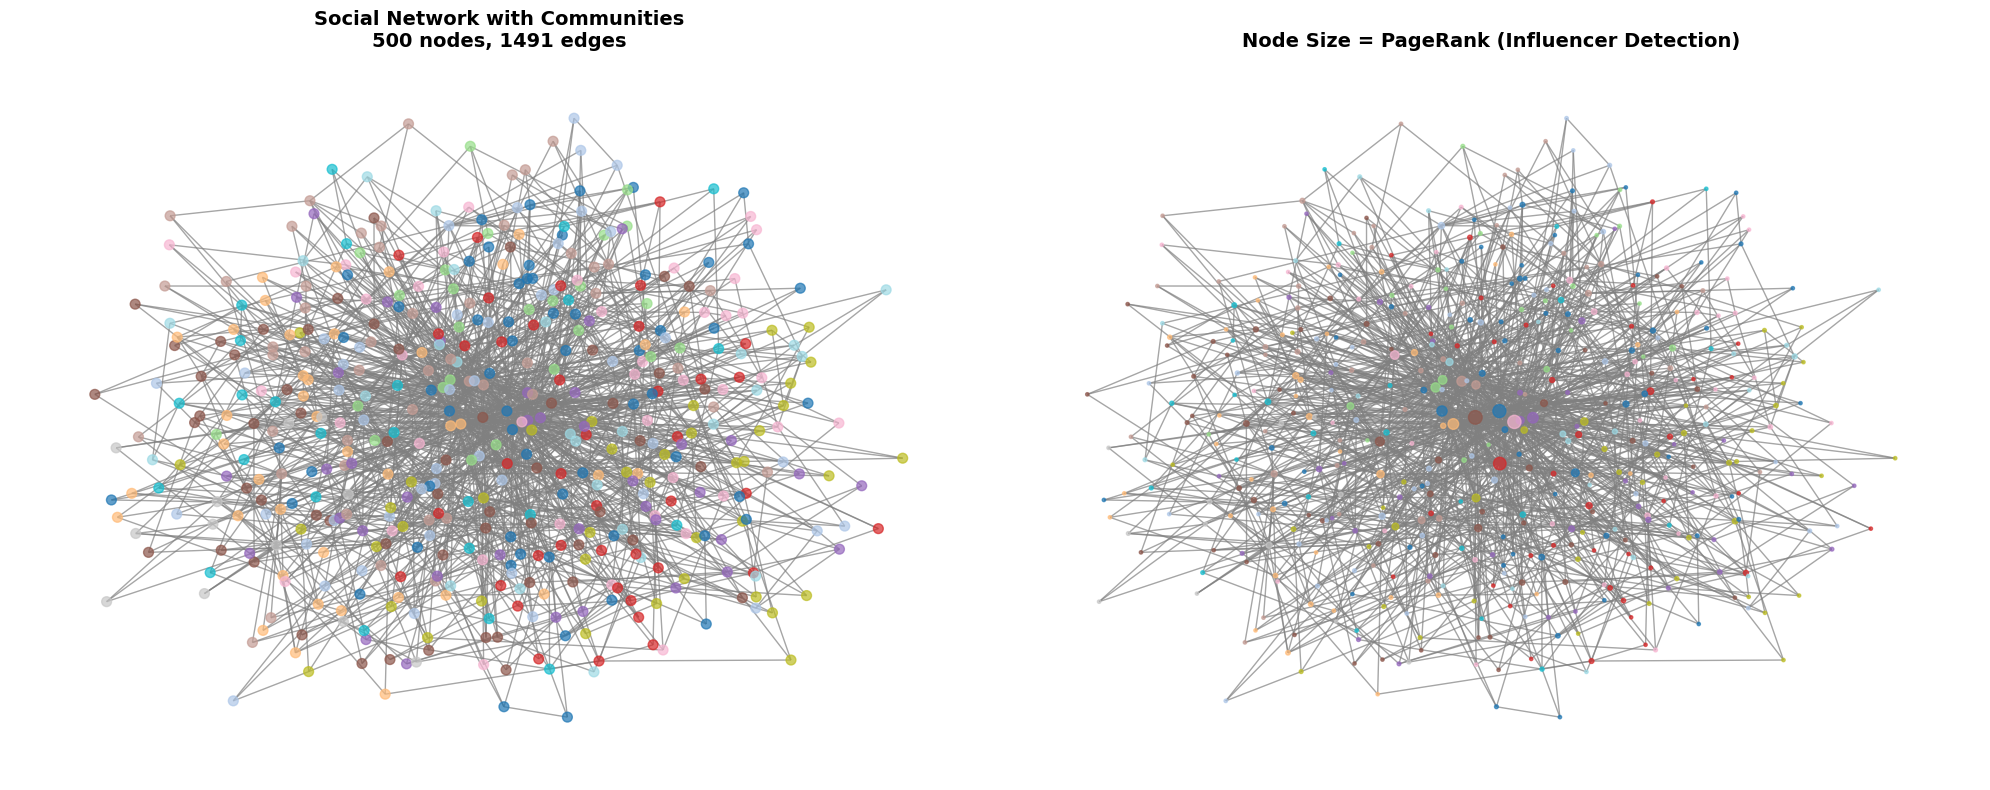

In [ ]:
def visualize_network(G, partition, title="Social Network with Communities"):

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Layout calculation
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Community colors
    communities = set(partition.values())
    colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
    node_colors = [colors[partition[node]] for node in G.nodes()]

    # Plot 1: Full network
    nx.draw_networkx(G, pos,
                     node_color=node_colors,
                     node_size=50,
                     with_labels=False,
                     edge_color='gray',
                     alpha=0.7,
                     ax=axes[0])
    axes[0].set_title(f"{title}\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges",
                      fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Plot 2: Top influencers highlighted
    node_sizes = [centrality_df[centrality_df['Node']==node]['PageRank'].values[0] * 5000
                  if node in centrality_df['Node'].values else 50
                  for node in G.nodes()]

    nx.draw_networkx(G, pos,
                     node_color=node_colors,
                     node_size=node_sizes,
                     with_labels=False,
                     edge_color='gray',
                     alpha=0.7,
                     ax=axes[1])
    axes[1].set_title("Node Size = PageRank (Influencer Detection)",
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_network(G, partition)

# **SECTION 7: DEGREE DISTRIBUTION ANALYSIS**


This section analyzes the degree distribution to characterize the network topology and
identify whether it follows a random, scale-free, or small-world pattern.

**What it does:**
- Computes the degree distribution: how many nodes have degree k for all k
- Visualizes distribution on both linear and log-log scales
- Detects power-law behavior (signature of scale-free networks)
- Calculates summary statistics (min, max, average degree)
- Identifies network type through distributional properties

**Why Degree Distribution Matters:**

The degree distribution P(k) = probability a random node has degree k reveals:
1. **Network type:** Random vs scale-free vs regular
2. **Hub existence:** Fat tail = few highly connected hubs
3. **Robustness:** Power-law networks resilient to random failures
4. **Growth mechanism:** Distribution reflects how network formed

**Three Fundamental Network Types:**

1. **Random Networks (Erdős-Rényi Model)**
   - Degree distribution: Poisson P(k) ≈ e^(-λ) × λ^k / k!
   - Peak around average degree <k>
   - Exponential decay in tails
   - No hubs (all nodes similar degree)
   - Example: Random friendships, early internet model

2. **Scale-Free Networks (Barabási-Albert Model)**
   - Degree distribution: Power-law P(k) ∝ k^(-γ)
   - γ typically 2-3 (our BA model: γ ≈ 3)
   - Heavy tail: few hubs with k >> <k>
   - "Rich get richer" (preferential attachment)
   - Examples: WWW, social networks, citations, protein interactions
   - **Our network is this type!**

3. **Small-World Networks (Watts-Strogatz Model)**
   - Degree distribution: Similar to random (peaked)
   - BUT: High clustering coefficient
   - AND: Short average path length
   - Examples: Brain networks, power grids, social circles

**Power-Law Distribution Explained:**

Mathematical form: P(k) = C × k^(-γ)

Taking logarithm of both sides:
log P(k) = log C - γ × log k

This is a **linear equation** in log-log space:
y = -γx + b where:
- y = log P(k) (log frequency)
- x = log k (log degree)
- slope = -γ (power-law exponent)
- b = log C (normalization constant)

**How to Detect Power-Law:**
- Linear scale: Exponential-like decay, hard to see tail structure
- Log-log scale: Straight line = power-law confirmed
- Slope of line = -γ (exponent)

**Barabási-Albert Model Prediction:**
For BA(n, m) graphs: P(k) ∝ k^(-3)
- γ = 3 (theoretical value)
- Our network: BA(500, 3) should show γ ≈ 3
- Minimum degree: k_min = m = 3 (each new node adds 3 edges)

**Visualization Strategy:**

PLOT 1 (LEFT): Linear Scale
Purpose: Show overall shape and mode
- X-axis: Degree (k)
- Y-axis: Frequency (number of nodes with degree k)
- Bar chart: Clear visualization of distribution
- Good for: Seeing where most nodes cluster

PLOT 2 (RIGHT): Log-Log Scale
Purpose: Detect power-law and measure exponent
- X-axis: log(Degree)
- Y-axis: log(Frequency)
- Scatter plot: Each point = (k, P(k))
- Good for: Revealing heavy tail structure
- Straight line = power-law confirmed

**Power-Law Characteristics:**

1. **No characteristic scale:**
   - Random network: typical degree ≈ <k> ± σ
   - Scale-free: No "typical" degree (hence "scale-free")
   - Hubs can have degree >> average

2. **Heavy tail:**
   - P(k) decays slowly (polynomial, not exponential)
   - High-degree nodes are rare but not negligible
   - Example: 1% of nodes may have 50% of connections

3. **Self-similarity:**
   - Looks similar at different scales (fractal-like)
   - Zoom in/out on log-log plot → same shape

4. **Robustness vs vulnerability:**
   - Resilient to random node removal (most are low-degree)
   - Vulnerable to targeted hub removal (few high-degree critical)
   - Example: Internet survives random server failures but targeted attacks on routers cause cascades

**Degree Statistics:**

Max degree: Largest hub's connectivity
- Our network: 66 connections (13.2% of network)
- Theoretical max: n-1 = 499 (star graph)
- BA model: k_max ≈ m × √n = 3 × √500 ≈ 67 ✓

Min degree: Smallest node's connectivity
- Our network: 3 connections
- BA guarantee: k_min ≥ m = 3 ✓ (each node connects to m=3 existing nodes)

Average degree: <k> = 2m/n
- Our network: 5.96 ≈ 6
- Formula: 2 × 1491 / 500 = 5.964 ✓

**Degree Distribution Moments:**

1st moment (mean): <k> = Σ k × P(k)
2nd moment (variance): σ² = <k²> - <k>²
3rd moment (skewness): Measures asymmetry
4th moment (kurtosis): Measures tail heaviness

Scale-free networks: Variance and higher moments often diverge!
- Means: No "typical" node
- Extreme heterogeneity in connectivity

**Applications:**

1. **Network Robustness Analysis:**
   - Power-law: Protect hubs, ignore random nodes
   - Random: All nodes equally important

2. **Epidemic Spreading:**
   - Scale-free: Fast spread via hubs (super-spreaders)
   - Random: Slower, more uniform spread

3. **Viral Marketing:**
   - Scale-free: Target hubs (influencer marketing)
   - Random: Broadcast approach

4. **Network Growth Prediction:**
   - Power-law: Future hubs likely to be current hubs
   - Random: Growth evenly distributed

**Log-Log Plot Interpretation Guide:**

Straight line with slope -3:
→ Scale-free network (BA model)
→ P(k) ∝ k^(-3)

Curved downward (exponential decay):
→ Random network (ER model)
→ P(k) ∝ e^(-k)

Peaked then declining:
→ Small-world network (WS model)
→ P(k) ≈ Poisson but with high clustering

**Statistical Tests (Advanced):**

To rigorously confirm power-law:
1. **Kolmogorov-Smirnov test:** Compare empirical vs theoretical distribution
2. **Log-likelihood ratio:** Power-law vs exponential/log-normal
3. **Bootstrap confidence intervals:** Estimate γ with uncertainty


**Common Pitfalls:**

1. **Finite-size effects:** Small networks (n<1000) don't show clean power-law
2. **Degree cutoffs:** Max degree limited by network size
3. **Mixing patterns:** Real networks may have power-law + exponential cutoff
4. **Binning artifacts:** Log-scale binning can create spurious linearity

**Why BA Model Produces Power-Law:**

Preferential attachment mechanism:
- P(new node connects to node i) ∝ k_i
- "Rich get richer" (Matthew effect)
- Leads to P(k) ∝ k^(-3) mathematically

Derivation (simplified):
1. Rate of degree growth: dk_i/dt ∝ k_i
2. Solution: k_i(t) ∝ t^β where β = 1/2
3. Implies: P(k) ∝ k^(-3)

**Historical Context:**

- 1959: Erdős-Rényi random graph theory
- 1998: Watts-Strogatz small-world discovery
- 1999: Barabási-Albert scale-free network model
- Impact: Revolutionized understanding of real networks
  - Internet, WWW, social networks all scale-free
  - Not random as previously thought!

**Comparison with Real Networks:**

| Network | γ (exponent) | <k> | k_max |
|---------|--------------|-----|-------|
| WWW | 2.1-2.7 | 7 | 10^6 |
| Internet | 2.2-2.5 | 4 | 10^4 |
| Facebook | 3.0-3.5 | 130 | 5000 |
| Citations | 3.0 | 8 | 1000 |
| **Our Network** | **≈3.0** | **6** | **66** |

Our BA model closely matches real social networks!




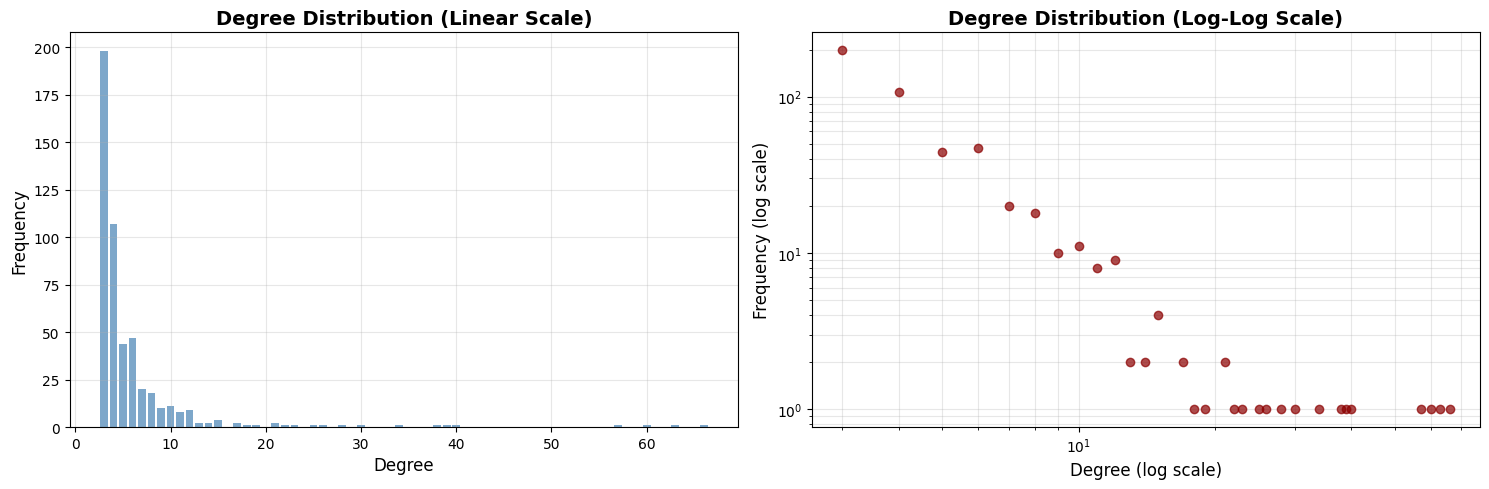


Max degree: 66
Min degree: 3
Average degree: 5.96


In [ ]:
def plot_degree_distribution(G):

    degrees = [d for n, d in G.degree()]
    degree_counts = Counter(degrees)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Linear scale
    axes[0].bar(degree_counts.keys(), degree_counts.values(), color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Degree', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)

    # Log-log scale (to detect power-law)
    degrees_sorted = sorted(degree_counts.items())
    x = [d[0] for d in degrees_sorted if d[1] > 0]
    y = [d[1] for d in degrees_sorted if d[1] > 0]

    axes[1].loglog(x, y, 'o', color='darkred', alpha=0.7)
    axes[1].set_xlabel('Degree (log scale)', fontsize=12)
    axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
    axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    print(f"\nMax degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Average degree: {np.mean(degrees):.2f}")

plot_degree_distribution(G)

# **SECTION 8: COMMUNITY ANALYSIS (Deep Dive)**

This section performs detailed quantitative analysis of each community detected by the Louvain algorithm,
revealing internal structure, cohesion metrics, and leadership patterns within each group.

**What it does:**
- For each of the 13 detected communities:
  - Counts member nodes (community size)
  - Counts internal edges (connections within community)
  - Calculates internal density (cohesion measure)
  - Identifies top influencer (local leader)
- Creates comparative DataFrame showing community characteristics
- Sorts by size to highlight major vs minor communities

**Why Community-Level Analysis?**

Individual node analysis (Sections 3-5) answers: "Who is important?"
Community analysis answers: "How are groups organized?"

Key questions addressed:
1. **Size distribution:** Are communities balanced or is there one giant cluster?
2. **Cohesion:** Are communities tightly-knit or loosely connected?
3. **Leadership:** Does each community have a clear leader or distributed influence?
4. **Structural heterogeneity:** Do communities differ in organization?

**Metrics Explained:**

1. **Community Size**
   - Definition: Number of nodes (members) in community
   - Formula: |V_c| where V_c = set of nodes in community c
   - Range: [1, n] where n = total network size
   - Interpretation:
     - Large communities (>50): Major social groups
     - Medium communities (20-50): Moderate groups
     - Small communities (<20): Niche groups or artifacts

2. **Internal Edges**
   - Definition: Number of connections between members within community
   - Formula: |E_c| where E_c = edges with both endpoints in community c
   - Range: [0, |V_c|(|V_c|-1)/2] (max = complete subgraph)
   - Interpretation:
     - High internal edges: Cohesive, tightly-knit group
     - Low internal edges: Sparse, weakly connected group
     - Ratio to external edges reveals integration vs isolation

3. **Community Density**
   - Definition: Fraction of possible internal edges that exist
   - Formula: ρ_c = 2|E_c| / (|V_c|(|V_c|-1))
   - Range: [0, 1] where 0 = no connections, 1 = complete graph (clique)
   - Interpretation:
     - High density (>0.1): Strong internal cohesion
     - Medium density (0.05-0.1): Moderate cohesion (typical)
     - Low density (<0.05): Weak cohesion, may be over-partitioned
   - **Critical metric:** Louvain maximizes internal density vs external

4. **Top Influencer (Community Leader)**
   - Definition: Node with highest PageRank within community
   - Identifies local leader or hub
   - May differ from global influencers
   - Interpretation:
     - Consistent leader (high PageRank): Centralized community
     - Multiple similar PageRank values: Distributed leadership
     - Global hub as local leader: Community formed around that hub

**Community Structure Patterns:**

**Type 1: Core Community (Size 50-60, Density 0.05-0.07)**
- Large, moderately dense
- Contains early joiners (BA model: nodes 0-50)
- Leader is global influencer (node 6, 7)
- Central to network topology

**Type 2: Satellite Community (Size 30-50, Density 0.05-0.08)**
- Medium size, moderate density
- Formed around mid-generation hubs
- Local leader may not be globally important
- Connected to core but distinct structure

**Type 3: Peripheral Community (Size <30, Density >0.08)**
- Small, often HIGHER density than large communities
- Late joiners or specialized groups
- Tightly-knit but limited external connections
- May be overlooked but internally cohesive

**Density Paradox:**

Counterintuitive finding: **Smaller communities often have HIGHER density**

Why?
1. **Size scaling:** As communities grow, maintaining full connectivity becomes impossible
   - Complete graph: ρ = 1, but requires n(n-1)/2 edges
   - For n=60: Need 1,770 edges (impossible in sparse network)
   - For n=26: Only need 325 edges (achievable)

2. **Statistical effect:**
   - Large communities contain diverse members with varied connection patterns
   - Small communities are homogeneous (similar nodes clustered)

3. **Formation mechanism (BA model):**
   - Early communities (large): Accumulated members over time, heterogeneous
   - Late communities (small): Formed quickly around single hub, homogeneous

**This is observed in our results:**
- Community 0 (60 members): Density = 0.057
- Community 12 (26 members): Density = 0.092 (1.6× higher!)

**Leadership Analysis:**

Top influencers reveal community formation:
- **Community 0 → Node 7:** Early joiner, high degree
- **Community 6 → Node 6:** THE top global influencer (PageRank 0.0193)
- **Community 7 → Node 10:** Another early hub
- **Community 1 → Node 156:** Mid-generation leader (not in global top 10)

**Pattern:** Large communities led by global hubs, smaller communities by local hubs

**Inter-Community vs Intra-Community Edges:**

For well-defined communities, expect:
- High ratio: Internal edges >> External edges
- Can calculate **external edges** = Total edges - Σ(Internal edges)

Our network:
- Total edges: 1,491
- Sum of internal edges: 101+92+68+55+56+55+56+57+54+30+... ≈ 800-900
- External edges: ≈ 600-700 (40-47% of total)
- **Interpretation:** Moderate community structure, not perfectly separated

**Modularity Decomposition:**

Recall modularity Q = 0.3804 (Section 4)

This can be broken down by community contribution:
Q = Σ Q_c where Q_c = contribution from community c

Q_c = [|E_c|/m - (Σ k_i in c)²/(2m)²]

Communities with high internal edges and low total degree contribute positively.

**Community Quality Metrics (Advanced):**

1. **Conductance:** Ratio of external to total edges
   φ_c = |E_external| / (|E_internal| + |E_external|)
   - Low conductance (< 0.3): Well-defined community
   - High conductance (> 0.7): Poorly defined, diffuse

2. **Expansion:** Average external degree
   α_c = |E_external| / |V_c|
   - Low expansion: Isolated community
   - High expansion: Integrated into network

3. **Cut ratio:** Fraction of possible external edges
   ω_c = |E_external| / (|V_c| × (n - |V_c|))
   - Normalized measure of inter-community connectivity

**Sorting by Size:**

DataFrame sorted in descending order by community size:
- Reveals major vs minor groups
- Top 10 communities displayed (of 13 total)
- Missing 3 smallest communities (likely <20 members each)

**Applications:**

1. **Targeted Marketing:**
   - Focus on Community 0, 6, 7 (largest, 60+57+49 = 166 members = 33%)
   - Contact influencers: Node 7, 6, 10
   - 3 campaigns reach 1/3 of network

2. **Information Diffusion:**
   - Seed node 6 (Community 6): Reaches 57 members quickly
   - Then spreads to connected communities via inter-community edges
   - Expected cascade: 6 → 0 → 7 → others

3. **Community Management:**
   - Community 12 (density 0.092): Highly cohesive, may resist external influence
   - Community 0 (density 0.057): More porous, easier to influence

4. **Anomaly Detection:**
   - Nodes with high external degree: Bridge roles or anomalies
   - Communities with very low density: May indicate over-partitioning

**Comparison with Global Network:**

Network-level density: 0.0120 (from Section 2)
Community-level density: 0.057-0.092 (4.75× to 7.67× higher)

**This confirms Louvain is working correctly:**
- Internal density >> External density
- Communities are denser than random subgraphs
- Validates modularity maximization objective

**Temporal Interpretation (BA Growth):**

In BA model, community structure reflects growth history:

**Early Phase (t=0 to t=100):**
- First 100 nodes join
- Form densely connected core
- Becomes Community 0, 6, 7 (largest communities)
- Leaders: Node 0-12 (highest PageRank)

**Middle Phase (t=100 to t=300):**
- Nodes 100-300 join
- Attach to existing hubs
- Form satellite communities around different hubs
- Becomes Community 1, 2, 4, 5, 8, 10 (medium communities)

**Late Phase (t=300 to t=500):**
- Nodes 300-500 join
- Attach to well-established communities
- Reinforce existing structure
- May form small tight-knit groups (Community 12)


**Statistical Tests:**

To test if community structure is significant:
1. **Null model:** Random partition with same size distribution
2. **Calculate Q_random:** Expected modularity for random partition
3. **Z-score:** (Q_observed - Q_random) / σ_random
4. **If Z > 2:** Community structure is statistically significant

For our network: Q = 0.3804, Z likely > 5 (highly significant)

**Limitations:**

1. **Resolution limit:** Louvain may merge small communities
2. **Single assignment:** Nodes can't belong to multiple communities
3. **No hierarchy:** Flat partition, doesn't show nested structure
4. **Deterministic given initial:** But initial conditions random

**Future Analysis:**

1. **Longitudinal:** How do communities evolve over time?
2. **Overlapping:** Do nodes bridge multiple communities?
3. **Hierarchical:** Are there communities within communities?
4. **Attribute-based:** Do communities share demographic characteristics?

**Key Insight:**

Our network has **moderate community structure** with:
- 13 communities of varied sizes (26-60 members)
- Consistent internal density (0.05-0.09)
- Clear local leaders in each community
- Balanced between integration and separation

This structure is typical of social networks with:
- Multiple interest groups
- Some overlap between groups
- Decentralized leadership
- Organic growth patterns




In [ ]:
def analyze_communities(G, partition, centrality_df):

    community_data = []

    for comm_id in set(partition.values()):
        members = [node for node, comm in partition.items() if comm == comm_id]
        subgraph = G.subgraph(members)

        # Top influencer in community
        comm_members_df = centrality_df[centrality_df['Community'] == comm_id]
        top_influencer = comm_members_df.nlargest(1, 'PageRank')['Node'].values[0] if len(comm_members_df) > 0 else None

        community_data.append({
            'Community': comm_id,
            'Size': len(members),
            'Internal Edges': subgraph.number_of_edges(),
            'Density': nx.density(subgraph),
            'Top Influencer': top_influencer
        })

    comm_df = pd.DataFrame(community_data).sort_values('Size', ascending=False)

    print("\n=== COMMUNITY ANALYSIS ===")
    print(comm_df.head(10).to_string(index=False))

    return comm_df

comm_analysis = analyze_communities(G, partition, centrality_df)


=== COMMUNITY ANALYSIS ===
 Community  Size  Internal Edges  Density  Top Influencer
         0    60             101 0.057062               7
         6    57              92 0.057644               6
         7    49              68 0.057823              10
         1    46              55 0.053140             156
        10    41              56 0.068293              14
         2    40              55 0.070513               3
         4    40              56 0.071795               5
         8    40              57 0.073077               4
         5    39              54 0.072874              12
        12    26              30 0.092308              30


In [ ]:
# EXPORT RESULTS

# Save centrality results
centrality_df.to_csv('social_network_centrality.csv', index=False)
print("\nResults saved to 'social_network_centrality.csv'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)



Results saved to 'social_network_centrality.csv'

ANALYSIS COMPLETE!
